# Set Proper Weight Path

In [1]:
weight_path='/media/ansary/DriveData/Work/bengalAI/banglaCraft/models/densenet121.h5'

# Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling

In [3]:

#--------------------
# up-conv implemented from paper
#--------------------

def upconv(x, n, filters):
    x = keras.layers.Conv2D(filters=filters, kernel_size=1, strides=1, name=f'upconv{n}.conv.0')(x)
    x = keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name=f'upconv{n}.conv.1')(x)
    x = keras.layers.Activation('relu', name=f'upconv{n}.conv.2')(x)
    x = keras.layers.Conv2D(filters=filters // 2,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            name=f'upconv{n}.conv.3')(x)
    x = keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name=f'upconv{n}.conv.4')(x)
    x = keras.layers.Activation('relu', name=f'upconv{n}.conv.5')(x)
    return x








def build_backbone(inputs,weights):
    backbone = tf.keras.applications.DenseNet121(include_top=False,
                                                    input_tensor=inputs,
                                                    weights=weights)
    return [backbone.get_layer(index=i).output for i in [311, 139, 51, 4]]


def base_model(input_shape=(512,512,3),weights=None):
    '''
        creates the craft model
        args:
            input_shape   :   the input shape of each image (defalut:(512,512,3))
            weights       :   weights for transfer learning (default:None, Available:imagenet)
        returns:
            a tf.keras model 
    '''
    inputs = keras.layers.Input(input_shape)

    s4, s3, s2, s1 = build_backbone(inputs=inputs,weights=weights)

    s5 = keras.layers.MaxPooling2D(pool_size=3, strides=1, padding='same',
                                   name='basenet.slice5.0')(s4)
    s5 = keras.layers.Conv2D(1024,
                             kernel_size=(3, 3),
                             padding='same',
                             strides=1,
                             dilation_rate=6,
                             name='basenet.slice5.1')(s5)
    s5 = keras.layers.Conv2D(1024,
                             kernel_size=1,
                             strides=1,
                             padding='same',
                             name='basenet.slice5.2')(s5)

    
    
    
    y = keras.layers.Concatenate()([s5, s4])
    y = upconv(y, n=1, filters=512)
    y = keras.layers.UpSampling2D(size=(2, 2),interpolation='bilinear')(y)
    
    y = keras.layers.Concatenate()([y, s3])
    y = upconv(y, n=2, filters=256)
    y = keras.layers.UpSampling2D(size=(2, 2),interpolation='bilinear')(y)
    
    y = keras.layers.Concatenate()([y, s2])
    y = upconv(y, n=3, filters=128)
    y = keras.layers.UpSampling2D(size=(2, 2),interpolation='bilinear')(y)
    
    y = keras.layers.Concatenate()([y, s1])
    
    features = upconv(y, n=4, filters=64)

    y = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same',
                            name='conv_cls.0')(features)
    y = keras.layers.Activation('relu', name='conv_cls.1')(y)
    y = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same',
                            name='conv_cls.2')(y)
    y = keras.layers.Activation('relu', name='conv_cls.3')(y)
    y = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same',
                            name='conv_cls.4')(y)
    y = keras.layers.Activation('relu', name='conv_cls.5')(y)
    y = keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='same',
                            name='conv_cls.6')(y)
    y = keras.layers.Activation('relu', name='conv_cls.7')(y)
    y = keras.layers.Conv2D(filters=2, kernel_size=1, strides=1, padding='same',
                            name='conv_cls.8')(y)
    y = keras.layers.Activation('sigmoid')(y)
    
    model = keras.models.Model(inputs=inputs, outputs=y)
    
    return model

model=base_model()
model.load_weights(weight_path)
print("loaded model weights")

loaded model weights


# Inference
* **properly give the image path to infer on**

In [12]:
img_path="iii.png"

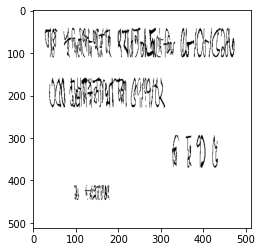

In [13]:
img=cv2.imread(img_path)
img=cv2.resize(img,(512,512))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [14]:
data=np.expand_dims(img,axis=0)
data=data/255.0
pred=model.predict(data)[0]
tmap=np.squeeze(pred[:,:,0])
lmap=np.squeeze(pred[:,:,1])


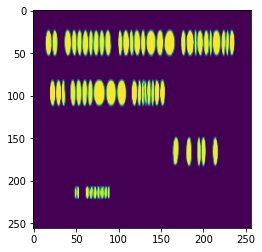

In [16]:
plt.imshow(tmap)

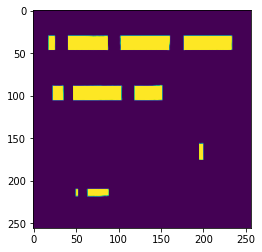

In [17]:
plt.imshow(lmap)

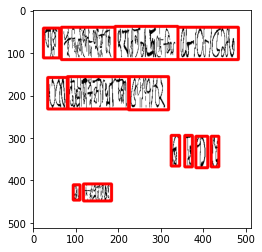

In [15]:
from coreLib.core import getBoxes,drawBoxes
boxes=getBoxes(tmap,lmap)
canvas=drawBoxes(img,boxes)
plt.imshow(canvas)
plt.show()